In [1]:
from MPLearn.embedding_notebook import *
from MPLearn.view_cells import *
import mysql.connector
initialize_notebook()

experiment_path = '../S25'
embedding_tag = "top_hits_plate_scaled_200522a_umap2_2M_15_0.0"


output_path = '../S25/product/figures/infected_20XX'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [3]:
def load_embedding():
    meta_columns=[
        'Image_Metadata_PlateID',
        'Image_Metadata_WellID',
        'Image_Metadata_FieldID',
        'ImageNumber',
        'plate_id',
        'Compound',
        'dose_nM',
        'Nuclei_Number_Object_Number',
        'Nuclei_AreaShape_Center_X',
        'Nuclei_AreaShape_Center_Y']

    embeddings = []

    top_hit_plate_ids = [
        '2006A', '2007A', '2008A', '2009A',
        '2010A', '2010A',          '2012A',
        '2013A', '2014A', '2015A', '2016A',
        '2017A',          '2019A']
    for plate_id in top_hit_plate_ids:
        embedding = load_single_embedding(
            experiment_path=experiment_path,
            embedding_tag=f"covid19cq1_SARS_{plate_id}_plate_scaled_into_{embedding_tag}",
            plate_id=f"covid19cq1_SARS_{plate_id}_plate_scaled",
            meta_columns=meta_columns,
            verbose=True)
        print(f"plate_id: {plate_id}, shape:({embedding.shape[0]},{embedding.shape[1]})")
        embeddings.append(embedding)

    embedding = load_single_embedding(
        experiment_path="../S25",
        embedding_tag=f"covid19cq1_SARS_1999B_200523_umap2_into_top_hits_plate_scaled_200522a_15_0.0",
        plate_id=f"lf_rem_plate_scaled_1999B_2020A",
        meta_columns=meta_columns,
        verbose=True)
    print(f"plate_id: {plate_id}, shape:({embedding.shape[0]},{embedding.shape[1]})")
    
    embeddings.append(embedding)
    embedding = pd.concat(embeddings)
    return embedding

embedding = load_embedding()

embedding['Plate_Name'] = 'SARS_' + embedding.plate_id
embedding.loc[embedding.plate_id == '1999B', 'Image_Metadata_PlateID'] = "20200427T024129"
embedding['microscope_plate_id'] = embedding.Image_Metadata_PlateID

cell_meta: '../S25/raw_data/covid19cq1_SARS_2006A_plate_scaled_Cell_MasterDataTable.parquet'
cell_meta shape: (1303699,10)
plate_id: 2006A, shape:(1303699,12)
cell_meta: '../S25/raw_data/covid19cq1_SARS_2007A_plate_scaled_Cell_MasterDataTable.parquet'
cell_meta shape: (901881,10)
plate_id: 2007A, shape:(901881,12)
cell_meta: '../S25/raw_data/covid19cq1_SARS_2008A_plate_scaled_Cell_MasterDataTable.parquet'
cell_meta shape: (1557415,10)
plate_id: 2008A, shape:(1557415,12)
cell_meta: '../S25/raw_data/covid19cq1_SARS_2009A_plate_scaled_Cell_MasterDataTable.parquet'
cell_meta shape: (917934,10)
plate_id: 2009A, shape:(917934,12)
cell_meta: '../S25/raw_data/covid19cq1_SARS_2010A_plate_scaled_Cell_MasterDataTable.parquet'
cell_meta shape: (754650,10)
plate_id: 2010A, shape:(754650,12)
cell_meta: '../S25/raw_data/covid19cq1_SARS_2010A_plate_scaled_Cell_MasterDataTable.parquet'
cell_meta shape: (754650,10)
plate_id: 2010A, shape:(754650,12)
cell_meta: '../S25/raw_data/covid19cq1_SARS_2012A_plat

In [3]:
embedding.shape

(18935875, 14)

In [5]:
%output size=400
embedding_plot = view_UMAP(embedding)
path_layer, regions_of_interest = draw_regions_of_interest()
embedding_plot * path_layer

:DynamicMap   []
   :Overlay
      .RGB.I    :RGB   [UMAP_1,UMAP_2]   (R,G,B,A)
      .Points.I :Points   [UMAP_1,UMAP_2]   (Image_Metadata_PlateID,Image_Metadata_WellID,Image_Metadata_FieldID,ImageNumber,plate_id,Compound,dose_nM,Cells_Number_Object_Number)
      .Path.I   :Path   [x,y]

In [2]:
print("Saving regions of interest...")
save_regions_of_interest(
    regions_of_interest=regions_of_interest,
    output_path=(
        f"{experiment_path}/intermediate_data/"
        f"{embedding_tag}/"
        f"infected_region_of_interest.parquet"))

print("Computing region of interest membership...")
ROI_membership = get_ROI_membership(
    regions_of_interest = regions_of_interest,
    points = embedding[['UMAP_1', 'UMAP_2']])

print("Saving region of interest membership...")
pa.parquet.write_table(
    table=pa.Table.from_pandas(ROI_membership),
    where=(
        f"{experiment_path}/intermediate_data/"
        f"{embedding_tag}/"
        f"infected_ROI_membreship.parquet"))

Saving regions of interest...


NameError: name 'regions_of_interest' is not defined

In [ ]:
%system
# Sample 2M infected cells:
cd ~/opt/MPStats/vignettes/SARS-CoV-2 &&
  Rscript scripts/3_sample_infected_cells.R
    
cd ~/opt/MPLearn/vignettes/SARS-CoV-2/S25/raw_data &&
  ln -s ../../../../../MPStats/vignettes/SARS-CoV-2/product/\
    top_hits_infected_plate_scaled_200604_Cell_MasterDataTable.parquet .
    
cd ~/opt/MPLearn/vignettes/SARS-CoV-2/S25 &
  ~/anaconda3/envs/sextonlab/bin/embed_umap \
    --dataset raw_data/top_hits_infected_plate_scaled_200604_Cell_MasterDataTable.parquet \
    --tag top_hits_infected_plate_scaled_200604_umap2_2M_15_0.0 \
    --feature_columns raw_data/cell_feature_columns.tsv \
    --no_standardize_features \
    --no_save_transform \
    --umap_n_neighbors 15 \
    --umap_low_memory \
    --verbose

In [ ]:
print("Adding roi_0 as the infected region to the full emebedding...")
ROI_membership = pa.parquet.read_table(
    f"{experiment_path}/intermediate_data/{embedding_tag}/infected_ROI_membreship.parquet").to_pandas()
embedding = pd.concat([embedding, ROI_membership], axis=1)

In [2]:

print("Loading re-embedding of infected region...")
meta_columns=[
    'Image_Metadata_PlateID',
    'Image_Metadata_WellID',
    'Image_Metadata_FieldID',
    'ImageNumber',
    'plate_id',
    'Compound',
    'dose_nM',
    'Lactoferrin_Concentration',
    'Remdesivir_Concentration',
    'Cells_RadialDistribution_RadialCV_Virus_5of8',
    'Nuclei_Number_Object_Number',
    'Nuclei_AreaShape_Center_X',
    'Nuclei_AreaShape_Center_Y']
infected_embedding = load_single_embedding(
    experiment_path=experiment_path,
    embedding_tag="UMAP_embedding_top_hits_infected_plate_scaled_epochs=2000_re_embed_epochs=2000_200730",
    plate_id="top_hits_infected_plate_scaled_200730",
    meta_columns=meta_columns)

print("Fixing meta data to locate images...")
infected_embedding['Plate_Name'] = 'SARS_' + infected_embedding.plate_id
infected_embedding.loc[infected_embedding.plate_id == '1999B', 'Image_Metadata_PlateID'] = "20200427T024129"
infected_embedding['microscope_plate_id'] = infected_embedding.Image_Metadata_PlateID

Loading re-embedding of infected region...
Fixing meta data to locate images...


In [39]:
datashader.__version__

'0.11.0'

In [10]:
%output size=250
def view_UMAP_feature(
        embedding,
        feature_id,
        label='',
        inv_color=False,
        color_pallet=viridis,
        background_color=None):
    """Return a HoloMap of a UMAP Embedding

    Input: embedding: Embedding with columns [<cell_meta_columns>, 'UMAP_1', 'UMAP_2']
           label: text label for the plot
    Output: A resizable HoloMap with tooltips with cell_meta columns for a sample of points
    """
    points = holoviews.Points(embedding, kdims=['UMAP_1', 'UMAP_2'], vdims=[feature_id], label=label)
    map = rasterize(points, aggregator=datashader.mean(feature_id))

    if inv_color:
        colormap = colormap_select(color_pallet[::-1])
    else:
        colormap = colormap_select(color_pallet)
    map = shade(map, color_key=colormap)
    map = dynspread(map, threshold=0.5)
    if (background_color is None) and not inv_color:
        map = map.options(bgcolor='black')
    hover_points = decimate(points)
    hover_points.opts(tools=['hover'], alpha=0)
    return (map * hover_points)

view_UMAP_feature(
    infected_embedding[ infected_embedding.Compound == 'Thioguanine'],
    feature_id = 'dose_nM',
    inv_color = True)

:DynamicMap   []
   :Overlay
      .RGB.I    :RGB   [UMAP_1,UMAP_2]   (R,G,B,A)
      .Points.I :Points   [UMAP_1,UMAP_2]   (dose_nM)

In [4]:
%output size=400
view_UMAP_clusters(infected_embedding)

:DynamicMap   []
   :Overlay
      .RGB.Cluster_12 :RGB   [UMAP_1,UMAP_2]   (R,G,B,A)
      .Labels.I       :Labels   [x,y]   (text)
      .Points.I       :Points   [UMAP_1,UMAP_2]   (Image_Metadata_PlateID,Image_Metadata_WellID,Image_Metadata_FieldID,ImageNumber,plate_id,Compound,dose_nM,Nuclei_Number_Object_Number,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,cluster_label)

In [8]:
%output size=400
view_UMAP(infected_embedding)

:DynamicMap   []
   :Overlay
      .RGB.I    :RGB   [UMAP_1,UMAP_2]   (R,G,B,A)
      .Points.I :Points   [UMAP_1,UMAP_2]   (Image_Metadata_PlateID,Image_Metadata_WellID,Image_Metadata_FieldID,ImageNumber,plate_id,Compound,dose_nM,Nuclei_Number_Object_Number,cluster_label,Plate_Name,microscope_plate_id)

In [7]:
image_config = {
    "database_connection_info" : "/home/ubuntu/.mysql/connectors.cnf",
    "database_options_group" : "covid19cq1",
    "S3_region" : 'us-east-1',
    "S3_bucket" : "sextoncov19",
    "S3_key_template" : "CQ1/{microscope_plate_id}_{plate_id}/Projection/W{Image_Metadata_WellID}F{Image_Metadata_FieldID}T0001Z000C{Dye_Number}.tif",
    "key_object" : "Nuclei",
    "dyes" : ["CMO", "Hoe", "Lipids", "Virus"],
    "saturations" : [0.20, 0.60, 0.15, 0.10],
    "color_maps" : ['Blues', 'Greens', 'viridis', 'inferno'],
    "width" : 150,
    "height" : 150,
    "verbose" : True
}

print("Collating instances...")
from MPLearn.view_cells import collate_cell_instances
collate_cell_instances(
    cell_ids = infected_embedding,
    group_dimension = "cluster_label",
    group_values = range(1, 13),
    n_instances_per_group = 30,
    output_fname = f"{experiment_path}/product/figures/infected_20XX/cluster_instances_workbook_30_exampels.xlsx",
    image_config = image_config,
    verbose = True)

Collating instances...
Getting example images for cluster_label=1...
Retriving information about the images for 30 cells from the database...
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2009A'
   Image_Metadata_WellID: '0080'
   Image_Metadata_FieldID: '0003'
   Nuclei_Number_Object_Number: '78'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2014A'
   Image_Metadata_WellID: '0344'
   Image_Metadata_FieldID: '0007'
   Nuclei_Number_Object_Number: '290'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2009A'
   Image_Metadata_WellID: '0356'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '166'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2015A'
   Image_Metadata_WellID: '0025'
   Image_Metadata_FieldID: '0002'
   Nuclei_Number_Object_Number: '191'
Getting coordinates for

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0025F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0025F0002T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0025F0002T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0308F0006T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0308F0006T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0308F0006T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0308F0006T0001Z000C4.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0367F0005T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0367F0005T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0367F0005T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0355F0009T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0355F0009T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0355F0009T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0355F0009T0001Z000C4.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 12
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 13
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 14
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 15
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 16
Making a montage of 4 images:
   pasting

Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2012A'
   Image_Metadata_WellID: '0334'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '320'
Retrieving the images from the S3 bucket...
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0221F0007T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0221F0007T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0221F0007T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0221F0007T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0186F0005T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.am

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0057F0006T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0057F0006T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0109F0007T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0109F0007T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0109F0007T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0109F0007T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0232F0006T0001Z000C1.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0334F0006T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0334F0006T0001Z000C4.tif
Assembling the images for 4 different dye images into a motage for each cell...
  making image for cell 0
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 1
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 2
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 3
Making a montage of 4 images:
   pasting image 

Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2008A'
   Image_Metadata_WellID: '0122'
   Image_Metadata_FieldID: '0001'
   Nuclei_Number_Object_Number: '441'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2013A'
   Image_Metadata_WellID: '0130'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '220'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2008A'
   Image_Metadata_WellID: '0039'
   Image_Metadata_FieldID: '0001'
   Nuclei_Number_Object_Number: '475'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2013A'
   Image_Metadata_WellID: '0219'
   Image_Metadata_FieldID: '0009'
   Nuclei_Number_Object_Number: '98'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2014A'
   Image_Metadata_WellID: '0300'
   Image_Metadata_FieldID: '

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0039F0009T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0039F0009T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0039F0009T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0039F0009T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0254F0001T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0254F0001T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0254F0001T0001Z000C3.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0124F0002T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0124F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0124F0002T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0124F0002T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0297F0002T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0297F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0297F0002T0001Z000C3.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
Getting example images for cluster_label=4...
Retriving information about the images for 30 cells from the database...
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2010A'
   Image_Metadata_WellID: '0273'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '92'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2012A'
   Image_Metadata_WellID: '0057'
   Image_Metadata_FieldID: '0005'
   Nuclei_Number_Object_Number: '443'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_1999B'
   Image_Metadata_WellID: '0171'
   Image_Metadata_FieldID: '0004'
   Nuclei_Number_Object_Number: '491'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name:

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0286F0009T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0286F0009T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0286F0009T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0286F0009T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0249F0009T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0249F0009T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0249F0009T0001Z000C3.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0316F0001T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0316F0001T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0316F0001T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0316F0001T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0138F0003T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0138F0003T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0138F0003T0001Z000C3.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 12
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 13
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 14
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 15
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 16
Making a montage of 4 images:
   pasting

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0326F0005T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0326F0005T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0326F0005T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0356F0004T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0356F0004T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0356F0004T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0356F0004T0001Z000C4.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0131F0007T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0131F0007T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0131F0007T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0347F0007T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0347F0007T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0347F0007T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0347F0007T0001Z000C4.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 6
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 7
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 8
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 9
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 10
Making a montage of 4 images:
   pasting ima

Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2010A'
   Image_Metadata_WellID: '0317'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '131'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_1999B'
   Image_Metadata_WellID: '0099'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '437'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2012A'
   Image_Metadata_WellID: '0286'
   Image_Metadata_FieldID: '0007'
   Nuclei_Number_Object_Number: '161'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2009A'
   Image_Metadata_WellID: '0074'
   Image_Metadata_FieldID: '0008'
   Nuclei_Number_Object_Number: '274'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2020A'
   Image_Metadata_WellID: '0352'
   Image_Metadata_FieldID: 

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0218F0009T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0218F0009T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0218F0009T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0275F0004T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0275F0004T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0275F0004T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0275F0004T0001Z000C4.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0343F0003T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0343F0003T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0343F0003T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0256F0002T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0256F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0256F0002T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0256F0002T0001Z000C4.tif
Retriving image from url: url S3://sexton

ERROR Writing value 'nan' to cell_info table in cell row=175 column=6
NAN/INF not supported in write_number() without 'nan_inf_to_errors' Workbook() option
ERROR Writing value 'nan' to cell_info table in cell row=176 column=6
NAN/INF not supported in write_number() without 'nan_inf_to_errors' Workbook() option
Getting example images for cluster_label=7...
Retriving information about the images for 30 cells from the database...
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2015A'
   Image_Metadata_WellID: '0110'
   Image_Metadata_FieldID: '0007'
   Nuclei_Number_Object_Number: '89'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2009A'
   Image_Metadata_WellID: '0379'
   Image_Metadata_FieldID: '0002'
   Nuclei_Number_Object_Number: '102'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2007A'
   Image_Metadata_WellID: '0008'
   Image_Metada

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0008F0006T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0097F0007T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0097F0007T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0097F0007T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200504T122350_2006A/Projection/W0097F0007T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0019F0003T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0019F0003T0001Z000C2.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200513T163153_2010A/Projection/W0033F0004T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0326F0008T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0326F0008T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0326F0008T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T225626_2019A/Projection/W0326F0008T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0042F0004T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0042F0004T0001Z000C2.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 11
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 12
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 13
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 14
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 15
Making a montage of 4 images:
   pasting

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0110F0003T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0110F0003T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0110F0003T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0366F0001T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0366F0001T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0366F0001T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0366F0001T0001Z000C4.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0350F0006T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0350F0006T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0350F0006T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0087F0009T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0087F0009T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0087F0009T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0087F0009T0001Z000C4.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 6
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 7
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 8
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 9
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 10
Making a montage of 4 images:
   pasting ima

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0038F0003T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0038F0003T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0038F0003T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0002F0002T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0002F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0002F0002T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0002F0002T0001Z000C4.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0085F0008T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0085F0008T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0085F0008T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0012F0004T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0012F0004T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0012F0004T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200505T041057_2007A/Projection/W0012F0004T0001Z000C4.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 6
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 7
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 8
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 9
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 10
Making a montage of 4 images:
   pasting ima

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0341F0001T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0341F0001T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0341F0001T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0152F0005T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0152F0005T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0152F0005T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200517T162410_2015A/Projection/W0152F0005T0001Z000C4.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0146F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0146F0002T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0146F0002T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0379F0008T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0379F0008T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0379F0008T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0379F0008T0001Z000C4.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 6
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 7
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 8
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 9
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 10
Making a montage of 4 images:
   pasting ima

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0310F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0310F0002T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200516T124719_2014A/Projection/W0310F0002T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0212F0002T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0212F0002T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0212F0002T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0212F0002T0001Z000C4.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0103F0007T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0103F0007T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0103F0007T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0152F0001T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0152F0001T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0152F0001T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0152F0001T0001Z000C4.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 6
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 7
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 8
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 9
Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
  making image for cell 10
Making a montage of 4 images:
   pasting ima

   Image_Metadata_WellID: '0225'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '155'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2013A'
   Image_Metadata_WellID: '0208'
   Image_Metadata_FieldID: '0003'
   Nuclei_Number_Object_Number: '161'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2009A'
   Image_Metadata_WellID: '0187'
   Image_Metadata_FieldID: '0005'
   Nuclei_Number_Object_Number: '76'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2007A'
   Image_Metadata_WellID: '0108'
   Image_Metadata_FieldID: '0001'
   Nuclei_Number_Object_Number: '99'
Getting coordinates for cell and for each dye in [CMO, Hoe, Lipids, Virus]:
   Plate_Name: 'SARS_2006A'
   Image_Metadata_WellID: '0154'
   Image_Metadata_FieldID: '0006'
   Nuclei_Number_Object_Number: '340'
Getting coordinates for cell and for each dye in [CMO, Hoe, L

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0174F0009T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200518T111037_2016A/Projection/W0174F0009T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0182F0008T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0182F0008T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0182F0008T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200509T135136_2009A/Projection/W0182F0008T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200515T153208_2013A/Projection/W0356F0004T0001Z000C1.tif
Retriving image from url: url S3://sexton

Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0331F0006T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200427T024129_1999B/Projection/W0331F0006T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0075F0007T0001Z000C1.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0075F0007T0001Z000C2.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0075F0007T0001Z000C3.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200502T154422_2008A/Projection/W0075F0007T0001Z000C4.tif
Retriving image from url: url S3://sextoncov19.s3.us-east-1.amazonaws.com/CQ1/20200514T113034_2012A/Projection/W0178F0009T0001Z000C1.tif
Retriving image from url: url S3://sexton

Making a montage of 4 images:
   pasting image CMO at (0, 0)
   pasting image Hoe at (0, 150)
   pasting image Lipids at (0, 300)
   pasting image Virus at (0, 450)
ERROR Writing value 'nan' to cell_info table in cell row=351 column=6
NAN/INF not supported in write_number() without 'nan_inf_to_errors' Workbook() option
ERROR Writing value 'nan' to cell_info table in cell row=355 column=6
NAN/INF not supported in write_number() without 'nan_inf_to_errors' Workbook() option


In [5]:
import functools
import operator
import PIL
import PIL.ImageOps
import boto3
import mysql.connector
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import os

In [6]:
con = mysql.connector.connect(
    option_files=os.path.expanduser("~/.mysql/connectors.cnf"),
    option_groups='covid19cq1')

S3_region = 'us-east-1'
S3_bucket = 'sextoncov19'


http://holoviews.org/reference/elements/bokeh/Image.html
http://holoviews.org/user_guide/Gridded_Datasets.html
    

http://holoviews.org/reference/containers/bokeh/HoloMap.html
   HoloViews data structure that contains a collection of Elements

http://holoviews.org/user_guide/Live_Data.html
   computes and displays elements dynamically


http://holoviews.org/user_guide/Responding_to_Events.html

http://holoviews.org/user_guide/Custom_Interactivity.html

http://holoviews.org/user_guide/Streaming_Data.html



In [ ]:
dmap = hv.DynamicMap(
    get_cell_image,
    kdims=[
        'plate_id',
        'Plate_Name',
        'Image_Metadata_WellID',
        'Image_Metadata_FieldID',
        'Cells_Number_Object_Number'])

In [ ]:
%%output size=300
def view_UMAP_cell_images(
        embedding,
        get_cell_image,
        kdims,
        label="",
        max_n_instances=1,
        random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(seed=14730219)

    dataset = holoviews.Dataset(embedding, ['UMAP_1', 'UMAP_2'])
    UMAP_1_range = (embedding.UMAP_1.min(), embedding.UMAP_1.max())
    UMAP_2_range = (embedding.UMAP_2.min(), embedding.UMAP_2.max())

    roi_box = holoviews.Polygons([])
    roi_box = roi_box.opts(holoviews.opts.Polygons(fill_alpha=0.2, line_color='white'))
    roi_stream = holoviews.streams.BoxEdit(source=roi_box)

    def cell_images(data):
        image = None
        import pdb; pdb.set_trace()
        if not data or not any(len(d) for d in data.values()):
            selection = dataset.select(UMAP_1=UMAP_1_range, UMAP_2=UMAP_2_range)
            if len(selection) > max_n_instances:
                selection = selection.iloc[random_state.choice(len(selection), max_n_instances, False)][kdims]
            import pdb; pdb.set_trace()
            image = get_cell_image(**selection)
            return image
        data = zip(data['x0'], data['x1'], data['y0'], data['y1'])
        for i, (x0, x1, y0, y1) in enumerate(data):
            print("  data is not none")
            selection = dataset.select(UMAP_1=(x0, x1), UMAP_2=(y0, y1))
            if len(selection) > max_n_instances:
                selection = selection.iloc[random_state.choice(len(selection), max_n_instances, False)][kdims]
            image = get_cell_image(**selection)
        return image
    dcell_images = holoviews.DynamicMap(cell_images, streams=[roi_stream])
    embedding_plot = view_UMAP(dataset, label=label)
    return embedding_plot * roi_box + dcell_images

view_UMAP_cell_images(
    embedding=infected_embedding,
    get_cell_image=get_cell_image,
    kdims=[
        'plate_id',
        'Plate_Name',
        'Image_Metadata_WellID',
        'Image_Metadata_FieldID',
        'Cells_Number_Object_Number'])

> <ipython-input-54-2d3ac47b6608>(22)cell_images()
-> if not data or not any(len(d) for d in data.values()):
(Pdb) n
> <ipython-input-54-2d3ac47b6608>(23)cell_images()
-> selection = dataset.select(UMAP_1=UMAP_1_range, UMAP_2=UMAP_2_range)
(Pdb) n
> <ipython-input-54-2d3ac47b6608>(24)cell_images()
-> if len(selection) > max_n_instances:
(Pdb) len(selection)
1999998
(Pdb) n
> <ipython-input-54-2d3ac47b6608>(25)cell_images()
-> selection = selection.iloc[random_state.choice(len(selection), max_n_instances, False)][kdims]
(Pdb) selection = selection.iloc[random_state.choice(len(selection), max_n_instances, False)]
(Pdb) selection
:Dataset   [UMAP_1,UMAP_2]   (Image_Metadata_PlateID,Image_Metadata_WellID,Image_Metadata_FieldID,ImageNumber,plate_id,Compound,dose_nM,Cells_Number_Object_Number,Plate_Name)
(Pdb) dir(selection)
['_Dataset__params', '_Dimensioned__abstract', '_Dimensioned__params', '_Element__abstract', '_Element__params', '_LabelledData__params', '_Parameterized__db_print', '_P

In [ ]:
tooltip_div = holoviews.Div("""
<div>
  <h1>Cell</h1>
  <canvas id="zztooltip-canvas" style='margin: 5px 5px 5px 5px' width="100" height="400"/>
</div>
""")
tooltip_div.options(width=100, height=400)

source = np.append(hmdb_embedding, hmdb_smiles[:,np.newaxis], axis=1)
source = ColumnDataSource(pd.DataFrame(data=hmdb_embedding, columns = ["x", "y", "smiles"]))

print("source.data.keys: {}".format(dir(source.data.keys())))
print("source.data['smiles'][1]: {}".format(source.data['smiles'][1]))

customjs = CustomJS(args=dict(source=hmdb_smiles), code="""
let smilesDrawer = new SmilesDrawer.Drawer({width:300, height:300}, debug=true);
SmilesDrawer.parse('CC(C)=C1CC2OC2(C)CC\C=C(C)/CC1=O', function(tree){
  console.log("In SmilesDrawer.parse call back");
  smilesDrawer.draw(tree, 'zztooltip-canvas', 'light', function(msg){console.log("ERROR drawing smiles msg:"+msg)});
});


//console.log("cb_data.index.properties.indices.spec['value']:" + cb_data.index.properties.indices.spec['value']);
//var indices = cb_data.index.properties.indices.spec["value"];
//let smilesDrawer = new SmilesDrawer.Drawer({width:300, height:300});
//for(i=0; i < indices.length; i++){
//    var smiles = source[indices[i]];
//    console.log("displaying smiles: "+smiles);
//    SmilesDrawer.parse(smiles, function(tree){
//      smilesDrawer.draw(tree, 'tooltip-canvas', 'light', function(msg){console.log("ERROR drawing smiles:"+smiles+" msg:"+msg)});
//    });
//} 
""")

#hover = HoverTool(callback=customjs,tooltips=None)
hover = HoverTool(callback=customjs, tooltips="HI")
hmdb_points = hmdb_points.opts(
    plot=dict(tools=[hover]),
    style=dict(color='orange'))




map = chembl_map * hmdb_points
map = map.options(
  bgcolor='white',
  yaxis=None,
  xaxis=None)
map + tooltip_div

In [28]:
def view_cells(
        cell_ids,
        database_connection_info,
        database_options_group,
        S3_region,
        S3_bucket,
        S3_key_template,
        key_object,
        dyes,
        saturations,
        color_maps,
        width,
        height,
        verbose=False):
    """
    Retrieve images and make them easy to see what what's going

    Example options for view_cells for the SARS-CoV-2 pseudo time experiment

        view_cells(
            database_connection_info="/home/ubuntu/.mysql/connectors.cnf",
            database_options_group="covid19cq1",
            S3_region="us-east-1",
            S3_bucket="umich-insitro",
            S3_key_template="{S3_path}/W{Image_Metadata_WellID}F{Image_Metadata_FieldID}T0001Z000C{Dye_Number}.tif",
            key_object="Nuclei",
            dyes=["Hoe", "NP", "ConA", "Spike"],
            saturations=[0.20, 0.50, 0.15, 0.4],
            color_maps=['Blues', 'Greens', 'viridis', 'inferno'],
            width=150,
            height=150,
            verbose=True)

    """
    if verbose:
        print(f"Retriving information about the images for {len(cell_ids)} cells from the database...")

    if not os.path.exists(database_connection_info):
        print("'database_connection_info' path does not exist. This is typically something like '/home/ubuntu/.mysql/connectors.cnf'. See 'https://dev.mysql.com/doc/refman/8.0/en/option-files.html' for more inforamtion")

    con = mysql.connector.connect(
        option_files=database_connection_info,
        option_groups=database_options_group)

    cell_coordinates = retrieve_cell_coordinates_from_db(
        con=con,
        cell_ids=cell_ids,
        key_object=key_object,
        dyes=dyes,
        verbose=verbose)

    if verbose:
        print(f"Retrieving the images from the S3 bucket...")
    dye_images = retrieve_cell_images_from_S3(
        S3_region=S3_region,
        S3_bucket=S3_bucket,
        S3_key_template=S3_key_template,
        cell_coordinates=cell_coordinates,
        verbose=verbose)

    n_dyes = len(dyes)
    if verbose:
        print(f"Assembling the images for {n_dyes} different dye images into a motage for each cell...")
    montages = []
    for cell_index in range(len(cell_ids)):
        cell_images = []
        if verbose:
            print(f"  making image for cell {cell_index}")
        for dye_index in range(len(dyes)):
            coords = cell_coordinates.iloc[cell_index*n_dyes + dye_index]
            dye_image = dye_images[cell_index*n_dyes + dye_index]

            dye_image = crop_image(
                image=dye_image,
                image_width=coords['Image_Width'],
                image_height=coords['Image_Height'],
                center_x=coords[f'{key_object}_AreaShape_Center_X'],
                center_y=coords[f'{key_object}_AreaShape_Center_Y'],
                width=width,
                height=height)

            dye_image = style_image(
                dye_image,
                saturation=saturations[dye_index],
                color_map=color_maps[dye_index])
            cell_images.append(dye_image)
        cell_images = montage_images(
            images=cell_images,
            labels=dyes,
            width=width,
            height=height,
            verbose=verbose)
        montages.append(cell_images)

    con.close()
    return montages


In [96]:
image_config = {
    "database_connection_info" : "/home/ubuntu/.mysql/connectors.cnf",
    "database_options_group" : "covid19cq1",
    "S3_region" : 'us-east-1',
    "S3_bucket" : "sextoncov19",
    "S3_key_template" : "CQ1/{microscope_plate_id}_{plate_id}/Projection/W{Image_Metadata_WellID}F{Image_Metadata_FieldID}T0001Z000C{Dye_Number}.tif",
    "key_object" : "Nuclei",
    "dyes" : ["Hoe", "Lipids", "CMO", "Virus"],
    "saturations" : [0.20, 0.60, 0.10, 0.05],
    "color_maps" : ['Blues', 'Greens', 'viridis', 'inferno'],
    "width" : 350,
    "height" : 350,
    "verbose" : True
}

cell = infected_embedding[(infected_embedding.cluster_label == 6) & (infected_embedding.Compound == 'Lactoferrin')][11:12]
print(cell)
montage = view_cells(cell, **image_config)[0]
neighbors = embedding[
    (embedding.Image_Metadata_PlateID == cell.Image_Metadata_PlateID.values[0]) &
    (embedding.Image_Metadata_WellID == cell.Image_Metadata_WellID.values[0]) &
    (embedding.Image_Metadata_FieldID == cell.Image_Metadata_FieldID.values[0])].copy()
neighbors['distance'] = np.sqrt(
    (neighbors.Nuclei_AreaShape_Center_X.values - cell.Nuclei_AreaShape_Center_X.values[0])**2 +
    (neighbors.Nuclei_AreaShape_Center_Y.values - cell.Nuclei_AreaShape_Center_Y.values[0])**2)
neighbors = neighbors[neighbors.distance < 113.3855] # 30mm
neighbors = neighbors[neighbors.roi_0 == False] # only the uninfected cells

infected_neighbors = infected_embedding[
    (infected_embedding.Image_Metadata_PlateID == cell.Image_Metadata_PlateID.values[0]) &
    (infected_embedding.Image_Metadata_WellID == cell.Image_Metadata_WellID.values[0]) &
    (infected_embedding.Image_Metadata_FieldID == cell.Image_Metadata_FieldID.values[0])].copy()
infected_neighbors['distance'] = np.sqrt(
    (infected_neighbors.Nuclei_AreaShape_Center_X.values - cell.Nuclei_AreaShape_Center_X.values[0])**2 +
    (infected_neighbors.Nuclei_AreaShape_Center_Y.values - cell.Nuclei_AreaShape_Center_Y.values[0])**2)
infected_neighbors = infected_neighbors[infected_neighbors.distance < 113.3855] # 30mm

print(f"N neighbors: {neighbors.shape[0]}")
print(f"N infected neighbors: {infected_neighbors.shape[0]}")

        Image_Metadata_PlateID Image_Metadata_WellID Image_Metadata_FieldID  \
2353343        20200427T024129                  0035                   0002   

         ImageNumber plate_id     Compound  dose_nM  \
2353343          308    1999B  Lactoferrin      NaN   

         Lactoferrin_Concentration  Remdesivir_Concentration  \
2353343                       25.0                       0.0   

         Nuclei_Number_Object_Number  Nuclei_AreaShape_Center_X  \
2353343                          547                      172.0   

         Nuclei_AreaShape_Center_Y    UMAP_1    UMAP_2  cluster_label  \
2353343                     1849.0 -3.609344 -1.906345              6   

         Plate_Name microscope_plate_id  
2353343  SARS_1999B     20200427T024129  
Retriving information about the images for 1 cells from the database...
Getting coordinates for cell and for each dye in [Hoe, Lipids, CMO, Virus]:
   Plate_Name: 'SARS_1999B'
   Image_Metadata_WellID: '0035'
   Image_Metadata_FieldID:

In [97]:
import PIL
from IPython.display import display

def add_network1(
    montage,
    cell,
    image_config,
    point_size = 6,
    line_width = 1,
    main_cell_color = (0, 255, 0),
    infected_cell_color = (255, 0, 0),
    uninfected_cell_color = (0, 0, 255),
    label_color = (255, 255, 0),
    label_font = None,
    label_size = 20,
    verbose = False):
    
    if label_font is None:
        label_font = PIL.ImageFont.truetype(
            font="/home/ubuntu/opt/MPLearn/MPLearn/Arimo/Arimo-Regular.ttf",
            size=label_size,
            index=0,
            encoding='')
    
    montage_draw = PIL.ImageDraw.Draw(montage)

    cell_x = cell.Nuclei_AreaShape_Center_X.values[0]
    cell_y = cell.Nuclei_AreaShape_Center_Y.values[0]
    
    if verbose:
        print(f"cell_x: {cell_x}, cell_y: {cell_y}")
    
    for dye_index in range(len(image_config['dyes'])):   
        crop_offset_x = cell_x - min(float(cell_x), float(image_config['width']/2))
        crop_offset_y = cell_y - min(float(cell_y), float(image_config['height']/2)) - dye_index * image_config['height']
        
        if verbose:
            print(f"adding network for dye {image_config['dyes'][dye_index]}")
            print(f"  crop_offset_x: {crop_offset_x}, crop_offset_y: {crop_offset_y}")

        for neighbor_index in range(neighbors.shape[0]):
            neighbor_x = neighbors.Nuclei_AreaShape_Center_X.values[neighbor_index] - crop_offset_x
            neighbor_y = neighbors.Nuclei_AreaShape_Center_Y.values[neighbor_index] - crop_offset_y
            
            if verbose:
                print(f"  uninfected neighbor index: {neighbor_index} neighbor_x: {neighbor_x}, neighbor_y:{neighbor_y}")
            
            montage_draw.line(
                (neighbor_x,
                 neighbor_y,
                 cell_x - crop_offset_x,
                 cell_y - crop_offset_y),
                fill=uninfected_cell_color,
                width=line_width)
            montage_draw.ellipse((
                neighbor_x-point_size/2,
                neighbor_y-point_size/2,
                neighbor_x+point_size/2,
                neighbor_y+point_size/2),
                fill=uninfected_cell_color)
            
            montage_draw.text(
                (neighbor_x+10, neighbor_y+1),
                "-1",
                font=label_font,
                fill=label_color)
            
            
        for neighbor_index in range(infected_neighbors.shape[0]):
            neighbor_x = infected_neighbors.Nuclei_AreaShape_Center_X.values[neighbor_index] - crop_offset_x
            neighbor_y = infected_neighbors.Nuclei_AreaShape_Center_Y.values[neighbor_index] - crop_offset_y

            if verbose:
                print(f"  infected neighbor index: {neighbor_index} neighbor_x: {neighbor_x}, neighbor_y:{neighbor_y}")            
            
            montage_draw.line(
                (neighbor_x,
                 neighbor_y,
                 cell_x - crop_offset_x,
                 cell_y - crop_offset_y),
                fill=infected_cell_color,
                width=line_width)
            montage_draw.ellipse((
                neighbor_x-point_size/2,
                neighbor_y-point_size/2,
                neighbor_x+point_size/2,
                neighbor_y+point_size/2),
                fill=infected_cell_color)            
            
            montage_draw.text(
                (neighbor_x+10, neighbor_y+1),
                str(infected_neighbors.cluster_label.values[neighbor_index]),
                font=label_font,
                fill=label_color)

        montage_draw.ellipse((
            cell_x - crop_offset_x - point_size/2, 
            cell_y - crop_offset_y - point_size/2,
            cell_x - crop_offset_x + point_size/2, 
            cell_y - crop_offset_y + point_size/2),
            fill=main_cell_color)

montage_graph = montage.copy()
add_network1(montage_graph, cell, image_config, verbose=True)

cell_x: 172.0, cell_y: 1849.0
adding network for dye Hoe
  crop_offset_x: 0.0, crop_offset_y: 1674.0
  infected neighbor index: 0 neighbor_x: 137.0, neighbor_y:107.0
  infected neighbor index: 1 neighbor_x: 172.0, neighbor_y:175.0
  infected neighbor index: 2 neighbor_x: 96.0, neighbor_y:194.0
  infected neighbor index: 3 neighbor_x: 236.0, neighbor_y:197.0
  infected neighbor index: 4 neighbor_x: 141.0, neighbor_y:242.0
adding network for dye Lipids
  crop_offset_x: 0.0, crop_offset_y: 1324.0
  infected neighbor index: 0 neighbor_x: 137.0, neighbor_y:457.0
  infected neighbor index: 1 neighbor_x: 172.0, neighbor_y:525.0
  infected neighbor index: 2 neighbor_x: 96.0, neighbor_y:544.0
  infected neighbor index: 3 neighbor_x: 236.0, neighbor_y:547.0
  infected neighbor index: 4 neighbor_x: 141.0, neighbor_y:592.0
adding network for dye CMO
  crop_offset_x: 0.0, crop_offset_y: 974.0
  infected neighbor index: 0 neighbor_x: 137.0, neighbor_y:807.0
  infected neighbor index: 1 neighbor_x: 1

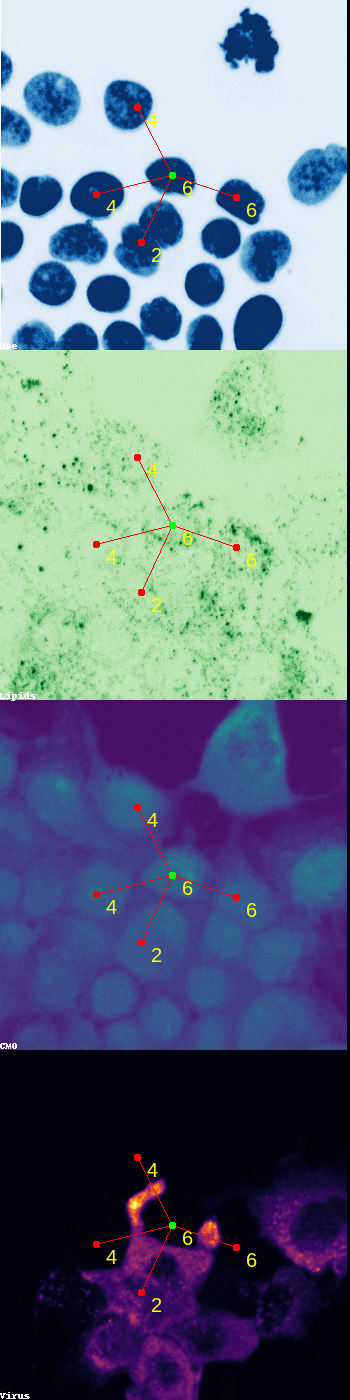

In [98]:
montage_graph